# Estimation of tree height using GEDI dataset -  Clean Data - Perceptron 2 - 2022

## Base on data quality flag select more reilable tree height.

In [44]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

**File storing tree hight (cm) obtained by 6 algorithms, with their associate quality flags.**
The quality flags can be used to refine and select the best tree height estimation and use it as tree height observation.

* a?_95: tree hight (cm) at 95 quintile, for each algorithm  
* min_rh_95: minimum value of tree hight (cm) ammong the 6 algorithms  
* max_rh_95: maximum value of tree hight (cm) ammong the 6 algorithms  
* BEAM: 1-4 coverage beam = lower power (worse) ; 5-8 power beam = higher power (better)  
* digital_elev: digital mdoel elevation  
* elev_low: elevation of center of lowest mode  
* qc_a?: quality_flag for six algorithms quality_flag = 1 (better); = 0 (worse)  
* se_a?: sensitivity for six algorithms sensitivity < 0.95 (worse);  sensitivity > 0.95  (beter )  
* deg_fg: (degrade_flag) not-degraded 0 (better) ;  degraded > 0 (worse)  
* solar_ele: solar elevation. > 0 day (worse); < 0 night (better)  

In [45]:
height_6algorithms = pd.read_csv("tree_height/txt/eu_y_x_select_6algorithms_fullTable.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
height_6algorithms.head(6)

ID         X          Y  a1_95  a2_95  a3_95  a4_95  a5_95  a6_95  \
0   1  6.050001  49.727499   3139   3139   3139   3120   3139   3139   
1   2  6.050002  49.922155   1022   2303    970    872   5596   1524   
2   3  6.050002  48.602377    380   1336    332    362   1336   1340   
3   4  6.050009  48.151979   3153   3142   3142   3127   3138   3142   
4   5  6.050010  49.588410    666   4221    651     33   5611   2723   
5   6  6.050014  48.608456    787   1179   1187    761   1833   1833   

   min_rh_95  max_rh_95  BEAM  digital_elev    elev_low  qc_a1  qc_a2  qc_a3  \
0       3120       3139     5         410.0   383.72153      1      1      1   
1        872       5596     5         290.0  2374.14110      0      0      0   
2        332       1340     4         440.0   435.97781      1      1      1   
3       3127       3153     2         450.0   422.00537      1      1      1   
4         33       5611     8         370.0  2413.74830      0      0      0   
5        761       1833     3         420.0   415.51581      1      1      1   

   qc_a4  qc_a5  qc_a6  se_a1  se_a2  se_a3  se_a4  se_a5  se_a6  deg_fg  \
0      1      1      1  0.962  0.984  0.968  0.962  0.989  0.979       0   
1      0      0      0  0.948  0.990  0.960  0.948  0.994  0.980       0   
2      1      1      1  0.947  0.975  0.956  0.947  0.981  0.968       0   
3      1      1      1  0.930  0.970  0.943  0.930  0.978  0.962       0   
4      0      0      0  0.941  0.983  0.946  0.941  0.992  0.969       0   
5      1      1      1  0.952  0.979  0.961  0.952  0.986  0.975       0   

   solar_ele  
0       17.7  
1       43.7  
2        0.2  
3      -14.2  
4       22.1  
5        0.2

In [46]:
height_6algorithms_sel = height_6algorithms.loc[(height_6algorithms['BEAM'] > 4) 
                                            &   (height_6algorithms['qc_a1'] == 1)
                                            &   (height_6algorithms['qc_a2'] == 1)
                                            &   (height_6algorithms['qc_a3'] == 1)    
                                            &   (height_6algorithms['qc_a4'] == 1)    
                                            &   (height_6algorithms['qc_a5'] == 1)    
                                            &   (height_6algorithms['qc_a6'] == 1)
                                            &   (height_6algorithms['se_a1'] > 0.95)    
                                            &   (height_6algorithms['se_a2'] > 0.95)
                                            &   (height_6algorithms['se_a3'] > 0.95)
                                            &   (height_6algorithms['se_a4'] > 0.95)
                                            &   (height_6algorithms['se_a5'] > 0.95)   
                                            &   (height_6algorithms['se_a6'] > 0.95)
                                            &   (height_6algorithms['deg_fg'] == 0)  
                                            &   (height_6algorithms['solar_ele'] < 0)]

In [47]:
height_6algorithms_sel

ID         X          Y  a1_95  a2_95  a3_95  a4_95  a5_95  \
7              8  6.050019  49.921613   3303   3288   3296   3236   3857   
11            12  6.050039  47.995344   2762   2736   2740   2747   3893   
14            15  6.050046  49.865317   1398   2505   2509   1316   2848   
15            16  6.050048  49.050020    984    943    947    958   2617   
16            17  6.050049  48.391359   3362   3332   3336   3351   4467   
...          ...       ...        ...    ...    ...    ...    ...    ...   
1267207  1267208  9.949829  49.216272   2160   2816   2816   2104   3299   
1267211  1267212  9.949856  49.881190   3190   3179   3179   3171   3822   
1267216  1267217  9.949880  49.873435   2061   2828   2046   2024   2828   
1267227  1267228  9.949958  49.127182    366   2307   1260    355   3531   
1267237  1267238  9.949999  49.936763   2513   2490   2490   2494   2490   

         a6_95  min_rh_95  max_rh_95  BEAM  digital_elev   elev_low  qc_a1  \
7         3292       3236       3857     7         320.0  297.68533      1   
11        2736       2736       3893     5         390.0  368.55121      1   
14        2505       1316       2848     6         340.0  330.40564      1   
15         947        943       2617     6         300.0  291.22598      1   
16        3336       3332       4467     5         530.0  504.78122      1   
...        ...        ...        ...   ...           ...        ...    ...   
1267207   2816       2104       3299     8         420.0  386.44556      1   
1267211   3179       3171       3822     6         380.0  363.69348      1   
1267216   2828       2024       2828     7         380.0  361.06812      1   
1267227   2719        355       3531     6         500.0  493.52792      1   
1267237   2490       2490       2513     5         360.0  346.54227      1   

         qc_a2  qc_a3  qc_a4  qc_a5  qc_a6  se_a1  se_a2  se_a3  se_a4  se_a5  \
7            1      1      1      1      1  0.971  0.988  0.976  0.971  0.992   
11           1      1      1      1      1  0.975  0.990  0.979  0.975  0.994   
14           1      1      1      1      1  0.973  0.990  0.979  0.973  0.994   
15           1      1      1      1      1  0.978  0.991  0.982  0.978  0.995   
16           1      1      1      1      1  0.973  0.988  0.977  0.973  0.992   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1267207      1      1      1      1      1  0.980  0.993  0.984  0.980  0.995   
1267211      1      1      1      1      1  0.968  0.986  0.974  0.968  0.990   
1267216      1      1      1      1      1  0.967  0.988  0.974  0.967  0.993   
1267227      1      1      1      1      1  0.973  0.989  0.978  0.973  0.993   
1267237      1      1      1      1      1  0.968  0.988  0.974  0.968  0.993   

         se_a6  deg_fg  solar_ele  
7        0.984       0      -33.9  
11       0.987       0      -37.3  
14       0.986       0      -18.2  
15       0.988       0      -35.4  
16       0.984       0       -5.1  
...        ...     ...        ...  
1267207  0.989       0      -16.9  
1267211  0.982       0      -35.1  
1267216  0.983       0      -35.1  
1267227  0.985       0      -36.0  
1267237  0.983       0      -32.2  

[226892 rows x 28 columns]

Calculate the mean height excluidng the maximum and minimum values 

In [48]:
height_sel =  pd.DataFrame({'ID' : height_6algorithms_sel['ID'] , 
                            'hm_sel': (height_6algorithms_sel['a1_95'] + height_6algorithms_sel['a2_95'] + height_6algorithms_sel['a3_95'] + height_6algorithms_sel['a4_95'] 
                             + height_6algorithms_sel['a5_95'] + height_6algorithms_sel['a6_95'] - height_6algorithms_sel['min_rh_95'] - height_6algorithms_sel['max_rh_95']) / 400 } )

In [49]:
height_sel

ID   hm_sel
7              8  32.9475
11            12  27.4625
14            15  22.2925
15            16   9.5900
16            17  33.4625
...          ...      ...
1267207  1267208  26.5200
1267211  1267212  31.8175
1267216  1267217  24.4075
1267227  1267228  16.6300
1267237  1267238  24.9100

[226892 rows x 2 columns]

## Import raw data, extracted predictors and show the data distribution

In [50]:
predictors = pd.read_csv("tree_height/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
# change column name
predictors = predictors.rename({'dev-magnitude':'devmagnitude'} , axis='columns')
predictors.head(10)

ID         X          Y        h  BLDFIE_WeigAver  CECSOL_WeigAver  \
0   1  6.050001  49.727499  3139.00             1540               13   
1   2  6.050002  49.922155  1454.75             1491               12   
2   3  6.050002  48.602377   853.50             1521               17   
3   4  6.050009  48.151979  3141.00             1526               16   
4   5  6.050010  49.588410  2065.25             1547               14   
5   6  6.050014  48.608456  1246.50             1515               19   
6   7  6.050016  48.571401  2938.75             1520               19   
7   8  6.050019  49.921613  3294.75             1490               12   
8   9  6.050020  48.822645  1623.50             1554               18   
9  10  6.050024  49.847522  1400.00             1521               15   

   CHELSA_bio18  CHELSA_bio4  convergence        cti  devmagnitude  eastness  \
0          2113         5893   -10.486560 -238043120      1.158417  0.069094   
1          1993         5912    33.274361 -208915344     -1.755341  0.269112   
2          2124         5983     0.045293 -137479792      1.908780 -0.016055   
3          2569         6130   -33.654274 -267223072      0.965787  0.067767   
4          2108         5923    27.493824 -107809368     -0.162624  0.014065   
5          2124         6010    -1.602039   17384282      1.447979 -0.018912   
6          2169         6147    27.856503  -66516432     -1.073956  0.002280   
7          1995         5912    22.102139 -297770784     -1.402633  0.309765   
8          1973         6138    18.496584  -25336536     -0.800016  0.010370   
9          2187         5886    -5.660453 -278652608      1.477951 -0.068720   

         elev  forestheight  glad_ard_SVVI_max  glad_ard_SVVI_med  \
0  353.983124            23         276.871094          46.444092   
1  267.511688            19         -49.526367          19.552734   
2  389.751160            21          93.257324          50.743652   
3  380.207703            27         542.401367         202.264160   
4  308.042786            25         136.048340         146.835205   
5  364.527100            18         221.339844         247.387207   
6  254.679596            19         125.250488          87.865234   
7  294.927765            26         -86.729492        -145.584229   
8  240.493759            22         -51.470703        -245.886719   
9  376.671143            12         277.297363         273.141846   

   glad_ard_SVVI_min  northness  ORCDRC_WeigAver  outlet_dist_dw_basin  \
0         347.665405   0.042500                9                780403   
1        -130.541748   0.182780               16                772777   
2         384.522461   0.036253               14                898820   
3         386.156738   0.005139               15                831824   
4         198.127441   0.028847               17                796962   
5         480.387939   0.042747               14                897945   
6         160.696777   0.037254               11                908426   
7        -190.062988   0.222435               15                772784   
8         172.074707   0.004428                8                839132   
9        -138.895996   0.098817               13                768873   

   SBIO3_Isothermality_5_15cm  SBIO4_Temperature_Seasonality_5_15cm  treecover  
0                   19.798992                            440.672211         85  
1                   20.889412                            457.756195         85  
2                   20.695877                            481.879700         62  
3                   19.375000                            479.410278         85  
4                   18.777500                            457.880066         85  
5                   19.398880                            474.331329         62  
6                   20.170450                            476.414520         96  
7                   20.855963                            457.195404         86  
8             

Merge the new height with the predictors table, using the ID as Primary Key

In [51]:
predictors_hm_sel = pd.merge( predictors ,  height_sel , left_on='ID' ,  right_on='ID' ,  how='right')

In [52]:
predictors_hm_sel.head(6)

ID         X          Y        h  BLDFIE_WeigAver  CECSOL_WeigAver  \
0   8  6.050019  49.921613  3294.75             1490               12   
1  12  6.050039  47.995344  2746.25             1523               12   
2  15  6.050046  49.865317  2229.25             1517               13   
3  16  6.050048  49.050020   959.00             1526               14   
4  17  6.050049  48.391359  3346.25             1489               19   
5  19  6.050053  49.877876   529.00             1531               12   

   CHELSA_bio18  CHELSA_bio4  convergence        cti  devmagnitude  eastness  \
0          1995         5912    22.102139 -297770784     -1.402633  0.309765   
1          2612         6181     3.549103  -71279992      0.507727 -0.021408   
2          2191         5901    31.054762 -186807440     -1.375050 -0.126880   
3          2081         6100     9.933455 -183562672     -0.382834  0.086874   
4          2486         5966    -6.957157 -273522688      2.989759  0.214769   
5          2184         5915   -24.278454 -377335296      0.265329 -0.248356   

         elev  forestheight  glad_ard_SVVI_max  glad_ard_SVVI_med  \
0  294.927765            26         -86.729492        -145.584229   
1  322.920227            26         660.006104          92.722168   
2  291.412537             7        1028.385498         915.806396   
3  246.288010            24         -12.283691         -58.179199   
4  474.409088            24         125.583008           6.154297   
5  335.534760            25         593.601074         228.712402   

   glad_ard_SVVI_min  northness  ORCDRC_WeigAver  outlet_dist_dw_basin  \
0        -190.062988   0.222435               15                772784   
1         190.979736  -0.034787               16                784807   
2         841.586182   0.024677               16                766444   
3         174.205566   0.094175               10                805730   
4         128.129150   0.017164               15                950190   
5         315.298340  -0.127365               17                764713   

   SBIO3_Isothermality_5_15cm  SBIO4_Temperature_Seasonality_5_15cm  \
0                   20.855963                            457.195404   
1                   20.798000                            460.501221   
2                   19.941267                            454.185089   
3                   19.849365                            470.946533   
4                   21.179420                            491.398376   
5                   19.760756                            448.580811   

   treecover   hm_sel  
0         86  32.9475  
1         97  27.4625  
2         54  22.2925  
3         78   9.5900  
4         85  33.4625  
5         96   5.2900

In [112]:
predictors_hm_sel = predictors_hm_sel.loc[(predictors['h'] < 5000) ]

In [113]:
predictors_hm_sel

ID         X          Y        h  BLDFIE_WeigAver  \
1            12  6.050039  47.995344  2746.25             1523   
2            15  6.050046  49.865317  2229.25             1517   
5            19  6.050053  49.877876   529.00             1531   
8            27  6.050083  49.281439  3921.25             1488   
9            35  6.050119  49.928610  1765.00             1510   
...         ...       ...        ...      ...              ...   
226876  1267176  9.949637  49.887471  3266.50             1558   
226878  1267180  9.949658  49.856387   497.00             1515   
226879  1267184  9.949688  49.362831  2344.00             1517   
226881  1267189  9.949701  49.114458  2014.50             1529   
226882  1267192  9.949731  49.893196  2891.00             1566   

        CECSOL_WeigAver  CHELSA_bio18  CHELSA_bio4  convergence        cti  \
1                    12          2612         6181     3.549103  -71279992   
2                    13          2191         5901    31.054762 -186807440   
5                    12          2184         5915   -24.278454 -377335296   
8                    13          2345         5915     3.646593 -223499248   
9                    13          1976         5917    -2.138205 -393005696   
...                 ...           ...          ...          ...        ...   
226876               14          2074         6484     4.993805 -196691680   
226878               17          1956         6561    34.034641 -126274136   
226879               15          2264         6499     9.173168  160967872   
226881               12          2608         6632    27.137199  104082784   
226882               15          2088         6482   -36.581142 -219142496   

        devmagnitude  eastness        elev  forestheight  glad_ard_SVVI_max  \
1           0.507727 -0.021408  322.920227            26         660.006104   
2          -1.375050 -0.126880  291.412537             7        1028.385498   
5           0.265329 -0.248356  335.534760            25         593.601074   
8           0.383314  0.062349  309.142609            25         862.362305   
9          -1.467515 -0.316702  301.649567            20         248.561035   
...              ...       ...         ...           ...                ...   
226876      1.260540  0.044238  328.019165            26        -144.124023   
226878     -0.959000  0.047194  260.889069             0         681.798340   
226879      0.645957 -0.011381  447.678040            23         282.119385   
226881     -0.481382 -0.012974  447.814392            21         187.934082   
226882      1.348770  0.060537  331.815918            21         -68.830078   

        glad_ard_SVVI_med  glad_ard_SVVI_min  northness  ORCDRC_WeigAver  \
1               92.722168         190.979736  -0.034787               16   
2              915.806396         841.586182   0.024677               16   
5              228.712402         315.298340  -0.127365               17   
8              263.612793         249.693115  -0.068810               16   
9              164.831299         237.283447  -0.144407               19   
...                   ...                ...        ...              ...   
226876        -145.522949         -14.317627   0.020914                7   
226878         657.745605         642.011475   0.050846                5   
226879          79.830811          10.140381   0.014716                7   
226881          90.763672         168.527100   0.045602               18   
226882        -160.909668          11.658203  -0.046048               11   

        outlet_dist_dw_basin  SBIO3_Isothermality_5_15cm  \
1                     784807                   20.798000   
2                     766444                   19.941267   
5                     764713                   19.760756   
8                     781120                   17.538614   
9                     773647                   21.324263   
...                      ...                         ...   
2

In [114]:
x_y_hm_sel = predictors_hm_sel[["X","Y","hm_sel"]]
x_y_hm_sel

X          Y   hm_sel
1       6.050039  47.995344  27.4625
2       6.050046  49.865317  22.2925
5       6.050053  49.877876   5.2900
8       6.050083  49.281439  39.2125
9       6.050119  49.928610  17.6500
...          ...        ...      ...
226876  9.949637  49.887471  32.6650
226878  9.949658  49.856387   4.9700
226879  9.949688  49.362831  23.4400
226881  9.949701  49.114458  20.1450
226882  9.949731  49.893196  28.9100

[116199 rows x 3 columns]

In [115]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(x_y_hm_sel)

(array([4.4490e+03, 2.5580e+03, 2.3750e+03, 2.2710e+03, 2.7280e+03,
        3.3330e+03, 4.4110e+03, 5.5060e+03, 6.5250e+03, 7.5690e+03,
        8.9780e+03, 1.0236e+04, 1.1240e+04, 1.0795e+04, 9.7710e+03,
        7.9490e+03, 5.6670e+03, 3.7270e+03, 2.4290e+03, 1.4340e+03,
        8.8400e+02, 4.8700e+02, 2.8500e+02, 1.5300e+02, 1.0600e+02,
        6.5000e+01, 4.1000e+01, 2.4000e+01, 2.9000e+01, 2.2000e+01,
        1.6000e+01, 2.0000e+01, 1.5000e+01, 1.2000e+01, 1.5000e+01,
        5.0000e+00, 9.0000e+00, 8.0000e+00, 7.0000e+00, 7.0000e+00,
        7.0000e+00, 3.0000e+00, 2.0000e+00, 7.0000e+00, 4.0000e+00,
        2.0000e+00, 4.0000e+00, 6.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

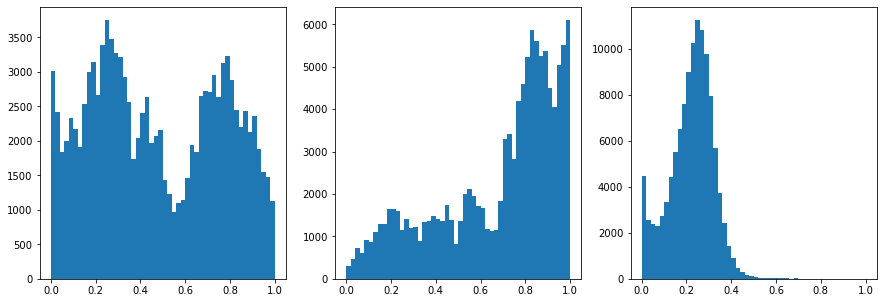

In [116]:
#Inspect the ranges 
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(data[:,0],50)
ax[1].hist(data[:,1],50)
ax[2].hist(data[:,2],50)

In [117]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(data[:,:2], data[:,2], test_size=0.30, random_state=0)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
print('X_train.shape: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train.shape: torch.Size([81339, 2]), X_test.shape: torch.Size([34860, 2]), y_train.shape: torch.Size([81339]), y_test.shape: torch.Size([34860])


In [142]:
class Perceptron(torch.nn.Module):
    def __init__(self,input_size, output_size, use_activation_fn=False):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size,output_size) # Initializes weights with uniform distribution centered in zero
        self.activation_fn = nn.ReLU() # instead of Heaviside step fn
        self.use_activation_fn = use_activation_fn # If we want to use an activation function
    def forward(self, x):
        output = self.fc(x)
        if self.use_activation_fn:
            output = self.activation_fn(output) # To add the non-linearity. Try training you Perceptron with and without the non-linearity
        return output

In [143]:
# Create percetron
model = Perceptron(input_size=2, output_size=1 , use_activation_fn=True)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [144]:
model.train()
epoch = 5000
all_loss=[]
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(X_train)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
   
    # Backward pass
    loss.backward()
    optimizer.step()
    
    all_loss.append(loss.item())

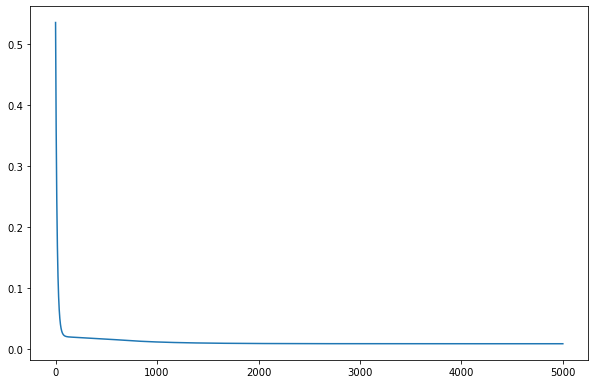

In [145]:
fig,ax=plt.subplots()
ax.plot(all_loss)

Test loss after Training 0.009606563486158848


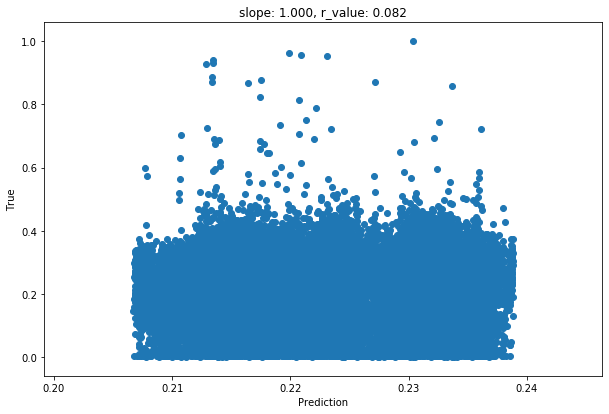

In [146]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    after_train = criterion(y_pred.squeeze(), y_test) 
    print('Test loss after Training' , after_train.item())

    y_pred = y_pred.detach().numpy().squeeze()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

    fig,ax=plt.subplots()
    ax.scatter(y_pred, y_test)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True')
    ax.set_title('slope: {:.3f}, r_value: {:.3f}'.format(slope, r_value))